# 소프트맥스 회귀

## 다항분류(다중 클래스 분류)의 이해

### 1) `다항 분류`

- `이진 분류`: `두 개의 선택지` 중 하나를 고르는 문제
- `다항 분류`: `세 개 이상의 선택지` 중 하나를 고르는 문제

### 2) `소프트맥스 함수`

- 다항 분류 활성화 함수
- 뉴런의 출력값에 대하여 class 분류를 위하여 마지막 단계에서 출력값에 대한 정규화를 해주는 함수.
- 결과물의 수치의 합은 언제나 1.0이다.
- 소프트맥스 함수의 출력값은 확률로 해석할 수 있다.

> 사진속 인물이 지금 슬픈 표정인지, 웃는 표정인지, 화난 표정인지 확률적으로 수치화한다고 했을때, 슬픔 (11%), 웃음 (29%), 화남(60%) 과같이 확률적 분류를 할 때 용이

![softmax](res/softmax.png)

- exp(x)는 지수함수(Exponential Function)이다(e는 자연상수).
- n은 출력층의 뉴런 수, yk는 그 중 k번째 출력을 뜻한다.

## #01 패키지 및 그래프 초기화

In [1]:
import sys
sys.path.append("../../")
import helper

import numpy as np
from pandas import read_excel, DataFrame, pivot_table
from matplotlib import pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

In [9]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.unicode_minus"] = False

## #02. 데이터셋 준비

- 아이리스(붓꽃)의 꽃잎에 대한 각 부분의 너비와 길이등을 측정한 데이터이며 150개의 레코드로 구성.
- 꽃받침의 길이, 너비, 꽃잎의 길이, 너비등을 토대로 3가지로 나뉘는 붗꽃의 종류를 분류하는 학습 모델을 구성할 수 있다

In [2]:
origin = read_excel("https://data.hossam.kr/F03/iris.xlsx")
origin.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


## #03. 데이터 전처리

### 결측치 확인

In [3]:
origin.isna().sum()

Sepal.Length    0
Sepal.Width     0
Petal.Length    0
Petal.Width     0
Species         0
dtype: int64

### 종속변수 라벨링을 위해 값의 종류 확인

In [4]:
uni = origin['Species'].unique()
print(uni)

['setosa' 'versicolor' 'virginica']


### 종속변수 라벨링

In [6]:
origin["Species"] = origin['Species'].astype('category').cat.rename_categories({'setosa': 0, 'virginica': 1, 'versicolor': 2})
origin['Species'].value_counts()

Species
0    50
2    50
1    50
Name: count, dtype: int64

## #04. 탐색적 데이터 분석

### 기본(기초)통계 확인

In [7]:
origin.describe()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


### 산점도 행렬 확인

> 종속변수로 `hue`를 적용했을 때 뚜렷한 군집을 나타내는지 확인하기 위함

다항분류에서 산점도 행렬을 통한 상관관계가 아닌 그룹별로 나누어지는 특성이 있는지를 확인 -> 군집화 가능 여부 확인

c:\Users\jehyu\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


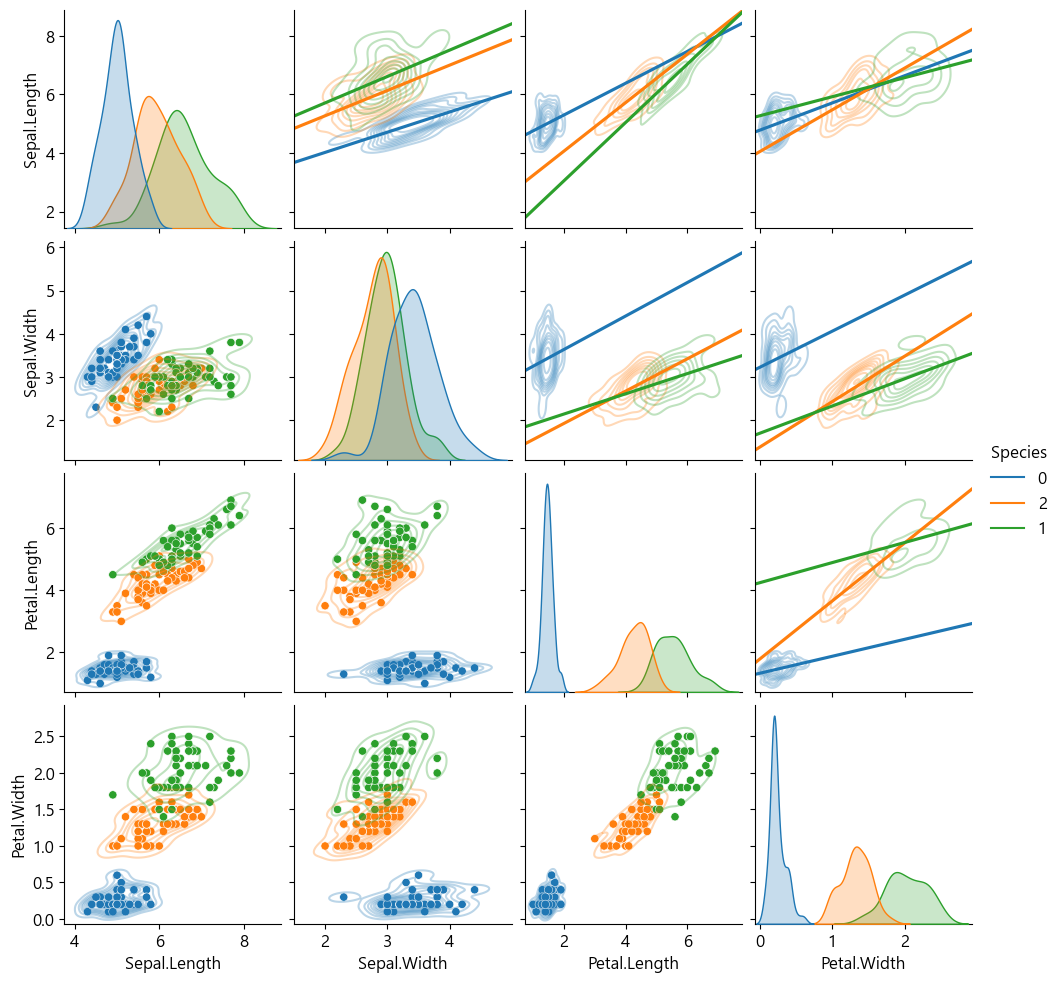

In [10]:
ax = sb.pairplot(origin, hue='Species', kind='kde', plot_kws={"alpha":0.3})
ax.map_lower(sb.scatterplot)
ax.map_upper(sb.regplot, scatter=False, truncate=False, ci=False)
plt.show()
plt.close()

## #05. 데이터셋 분할

### 랜덤시드 고정

In [11]:
np.random.seed(777)

### 훈련 데이터(독립변수)와 레이블(종속변수) 구분

In [12]:
x = origin.drop(["Species"], axis=1)
y = origin["Species"]
x.shape, y.shape

((150, 4), (150,))

### 종속변수에 대한 one-hot-encoding

통상적인 더미변수 처리.

단, 계산(회귀식)을 위한 처리가 아닌 `분류를 위한 처리`이므로 `첫 번째 항목 제외 금지`.

In [13]:
y

0      0
1      0
2      0
3      0
4      0
      ..
145    1
146    1
147    1
148    1
149    1
Name: Species, Length: 150, dtype: category
Categories (3, int64): [0, 2, 1]

In [14]:
y_cate = to_categorical(y)
print(y_cate)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0.

> 3개 같은 1개의 종속변수

### 훈련 데이터/검증 데이터 분할

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y_cate, test_size=0.3, random_state=777)
print("훈련용 데이터셋 크기 : %s, 훈련용 레이블셋 크기 : %s" % (x_train.shape, y_train.shape))
print("검증용 데이터셋 크기 : %s, 검증용 레이블셋 크기 : %s" % (x_test.shape, y_test.shape))

훈련용 데이터셋 크기 : (105, 4), 훈련용 레이블셋 크기 : (105, 3)
검증용 데이터셋 크기 : (45, 4), 검증용 레이블셋 크기 : (45, 3)


## #06. 모델 개발

### 모델 정의

> relu, sigmoid, rmsporp, binary_crossentropy, acc

- input_shape은 독립변수 수
- Dense(출력 수) 신경망 개수의 수에 따라서 모델의 성능에 차이가 발생
    - 직감으로 맞춤(다른 방법 없음) 보통 16 또는 32 이상
    - 최적의 값을 직접 탐색(너무 많으면 컴퓨터 다운)
- activation은 모델과 분석 종류에 따라서 다름 
    - 보통 시작은 relu, 분류는 sigmoid, 회귀는 linear
- optimizer은 모르면 Adam
- epochs는 많아도 크게 상관이 없음
- 2차항을 하고 싶다면 sklearn으로 2차항 생성 후 Sequential에 입력

In [16]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(4, )))
model.add(Dense(3, activation='softmax'))   #종속변수 3개->Dense를 3으로
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 515 (2.01 KB)
Trainable params: 515 (2.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 학습하기

In [17]:
result = model.fit(x_train, y_train, epochs=500, validation_data=(x_test, y_test), callbacks=[
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1)
])

Epoch 1/500
4/4 [==============================] - 1s 115ms/step - loss: 1.1271 - acc: 0.3143 - val_loss: 0.8584 - val_acc: 0.6222 - lr: 0.0010
Epoch 2/500
4/4 [==============================] - 0s 18ms/step - loss: 0.9507 - acc: 0.5905 - val_loss: 0.7643 - val_acc: 0.7556 - lr: 0.0010
Epoch 3/500
4/4 [==============================] - 0s 17ms/step - loss: 0.8409 - acc: 0.6286 - val_loss: 0.7192 - val_acc: 0.7556 - lr: 0.0010
Epoch 4/500
4/4 [==============================] - 0s 17ms/step - loss: 0.7698 - acc: 0.6286 - val_loss: 0.7038 - val_acc: 0.7333 - lr: 0.0010
Epoch 5/500
4/4 [==============================] - 0s 15ms/step - loss: 0.7351 - acc: 0.7429 - val_loss: 0.7027 - val_acc: 0.7111 - lr: 0.0010
Epoch 6/500
4/4 [==============================] - 0s 16ms/step - loss: 0.7123 - acc: 0.7143 - val_loss: 0.6967 - val_acc: 0.6444 - lr: 0.0010
Epoch 7/500
4/4 [==============================] - 0s 17ms/step - loss: 0.6966 - acc: 0.6857 - val_loss: 0.6823 - val_acc: 0.6222 - lr: 0.001

## #07. 학습 결과 평가

### 기본적인 머신러닝 학습결과 평가

F.\03.\08(데이터프레임화, 손실률 시각화) 참고

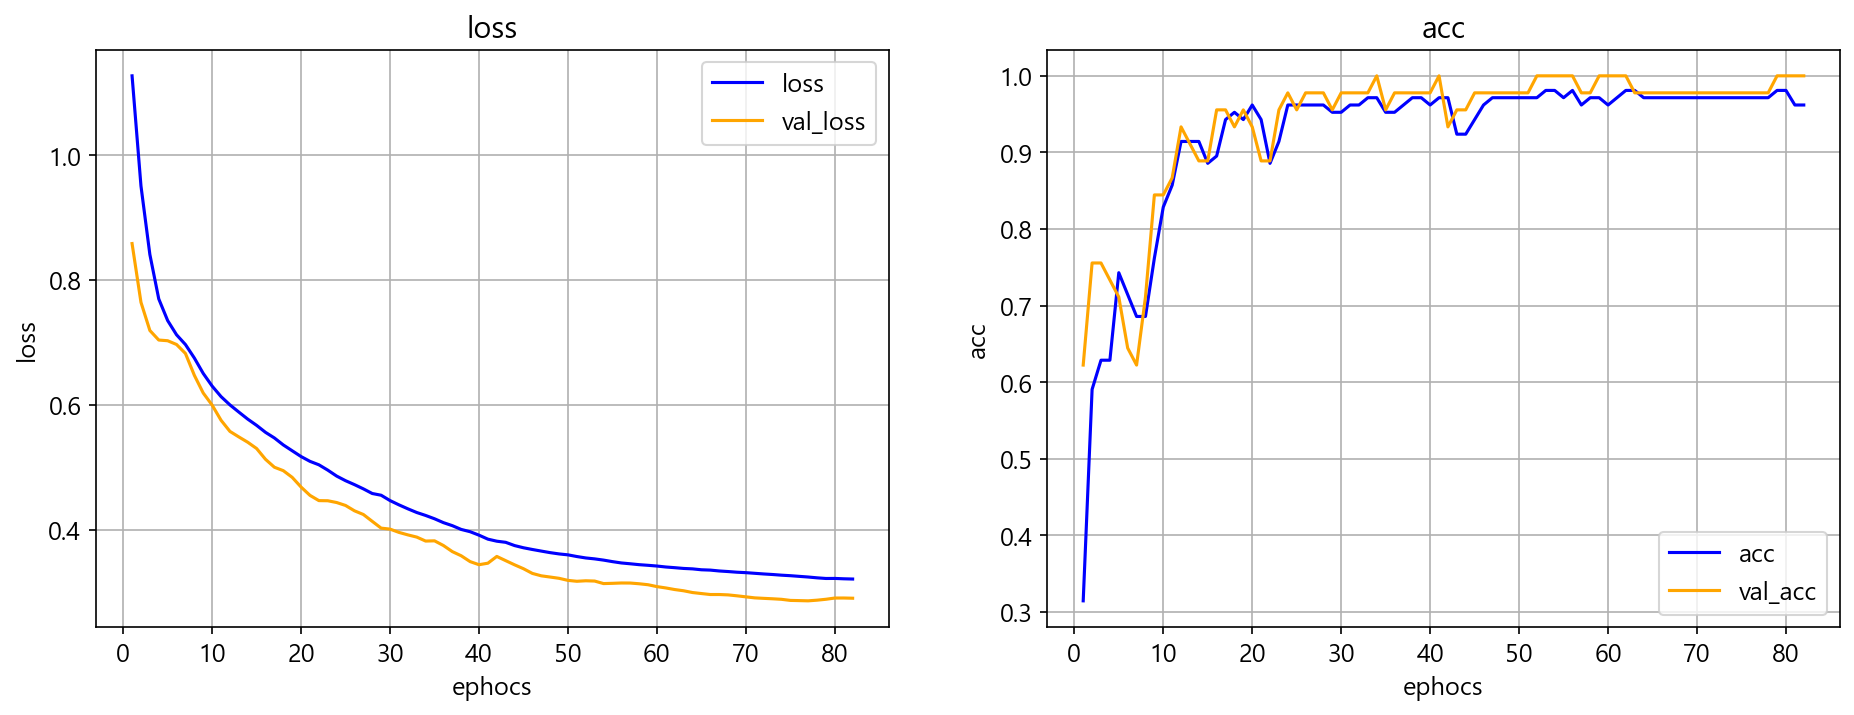

4/4 [==============================] - 0s 3ms/step - loss: 0.3206 - acc: 0.9619
최종 훈련 손실률 : 0.320579, 최종 훈련 정확도 : 0.961905
2/2 [==============================] - 0s 5ms/step - loss: 0.2902 - acc: 1.0000
최종 검증 손실률 : 0.290243, 최종 검증 정확도 : 1.000000


In [18]:
helper.tf_result_plot(result)

evaluate1 = model.evaluate(x_train, y_train)
print("최종 훈련 손실률 : %f, 최종 훈련 정확도 : %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test, y_test)
print("최종 검증 손실률 : %f, 최종 검증 정확도 : %f" % (evaluate2[0], evaluate2[1]))

## #08. 학습 결과 적용

### 테스트 데이터에 대한 예측 결과 산정

In [19]:
results = model.predict(x_test)
data_count, case_count = results.shape
print("%d개의 검증 데이터가 각각 %d개의 경우의 수를 갖는다." % (data_count, case_count))

print(results)

2/2 [==============================] - 0s 2ms/step
45개의 검증 데이터가 각각 3개의 경우의 수를 갖는다.
[[2.3351568e-03 6.7544556e-01 3.2221928e-01]
 [9.3675584e-01 4.4057220e-03 5.8838483e-02]
 [2.7981913e-03 6.5716785e-01 3.4003395e-01]
 [4.5181769e-03 7.1263009e-01 2.8285173e-01]
 [2.0078696e-02 3.8049564e-01 5.9942573e-01]
 [9.7088188e-01 1.6117165e-03 2.7506329e-02]
 [1.9657987e-03 6.4226019e-01 3.5577404e-01]
 [2.8420379e-03 7.2421533e-01 2.7294260e-01]
 [9.6368635e-01 1.8604730e-03 3.4453202e-02]
 [9.6197051e-01 2.5216944e-03 3.5507794e-02]
 [2.0490151e-03 6.7587459e-01 3.2207638e-01]
 [2.1528699e-02 3.5239777e-01 6.2607348e-01]
 [3.1173220e-02 3.3469200e-01 6.3413483e-01]
 [6.0502165e-03 5.4845250e-01 4.4549736e-01]
 [6.0583330e-03 6.7656273e-01 3.1737894e-01]
 [4.7484911e-03 6.5620667e-01 3.3904487e-01]
 [9.3197423e-01 5.1157954e-03 6.2909968e-02]
 [7.4262517e-03 5.0914019e-01 4.8343354e-01]
 [9.0767884e-01 6.6572889e-03 8.5663944e-02]
 [3.0739754e-02 3.4312719e-01 6.2613302e-01]
 [4.7106121e-02 2

### 가장 큰 확률 값의 인덱스들만 별도의 리스트로 생성

In [20]:
arg_results = np.argmax(results, axis=-1)
arg_results

array([1, 0, 1, 1, 2, 0, 1, 1, 0, 0, 1, 2, 2, 1, 1, 1, 0, 1, 0, 2, 2, 2,
       1, 0, 1, 0, 2, 0, 1, 1, 0, 1, 0, 1, 2, 0, 0, 0, 2, 0, 0, 1, 2, 2,
       0], dtype=int64)

### 결과 데이터 셋 구성

In [21]:
result_df = DataFrame({
    '실제값': np.argmax(y_test, axis = -1),
    '분류결과': arg_results
})

result_df

,실제값,분류결과
0,1,1
1,0,0
2,1,1
3,1,1
4,2,2
5,0,0
6,1,1
7,1,1
8,0,0
9,0,0


### 컬럼에 따른 값의 종류 형태로 데이터 재배치

In [22]:
mdf = result_df.melt()
mdf.reset_index(inplace=True)
mdf

,index,variable,value
0,0,실제값,1
1,1,실제값,0
2,2,실제값,1
3,3,실제값,1
4,4,실제값,2
...,...,...,...
85,85,분류결과,0
86,86,분류결과,1
87,87,분류결과,2
88,88,분류결과,2


In [23]:
df = pivot_table(mdf, index='value', columns='variable', values='index', aggfunc='count')
df

variable,분류결과,실제값
value,,
0,17,17
1,17,17
2,11,11


In [24]:
cm = confusion_matrix(result_df['실제값'], result_df['분류결과'])
cmdf1 = DataFrame(cm, index=[['실제값', '실제값', '실제값'], [0,1,2]], 
                  columns=[['분류결과', '분류결과', '분류결과'], [0,1,2]])
cmdf1

분류결과        
         0   1   2
실제값 0   17   0   0
    1    0  17   0
    2    0   0  11